In this notebook different quantisation methods and distance metrics for Facial Recognition will be compared both on accuracy and execution time. 

The Quantisation methods include:
- Scalar Quantisation
- TensorFlow Quantisation

The distance metrics include:
- Cosine Similarity
- Euclidean Distance

Below are the necassary import to run the code.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # suppress tensorflow warnings https://stackoverflow.com/a/40871012
from deepface import DeepFace
import subprocess
import numpy as np
from decimal import Decimal # for proper rounding
import random
import time
import pandas as pd
from datetime import datetime
import struct
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import statistics
import accuracy as ac
import pickle
import quantisations as qt
import basics as bs


# CONSTANTS
EXECUTABLE_PATH = "ABY/build/bin"
INPUT_FILE_NAME = "input_vecs.txt"
EXECUTABLE_NAME_SCENARIO = 'cos_dist_copy'
CMD_SCENARIO = f"./{EXECUTABLE_NAME_SCENARIO} -r 1 -f {INPUT_FILE_NAME} & (./{EXECUTABLE_NAME_SCENARIO} -r 0 -f {INPUT_FILE_NAME} 2>&1 > /dev/null)"

# random number generator
rng = np.random.default_rng()

Below are two functions to compare Facenet and Sface accuracy. One for Euclidean Distance and one for Cosine Similarity. The code to create a visual representation for this comparison is also included.

In [2]:
### GENERATING THE GLOBAL PAIRS. 
### we only need to run this once and then we can have the file and use pairs as the list of embeddings 
### uncomment to use for first them, then use the next cell!

#
# Generate pairs globally
def generate_pairs(m):
    pairs = []
    for _ in range(m):
        # print(_)
        n = random.choice([True, False])
        a, b, imga, imgb = bs.get_two_random_embeddings_facenet(same_person=n)
        pairs.append((a, b, imga, imgb,n))
    return pairs

m = 10
pairs = generate_pairs(m)

# File path
file_path = 'embedingpairs.pkl'

# Delete the file if it exists
if os.path.exists(file_path):
    os.remove(file_path)

# Save pairs to a new file
with open(file_path, 'wb') as file:
    pickle.dump(pairs, file)

0
1
2
3
4
5
6
7
8
9


In [3]:
with open(file_path, 'rb') as file:
    pairs = pickle.load(file)

In [13]:
def extract_results(counters):
    methods = []
    correct_sface_euc = []
    incorrect_sface_euc = []
    correct_sface_cos = []
    incorrect_sface_cos = []
    correct_facenet_euc = []
    incorrect_facenet_euc = []
    correct_facenet_cos = []
    incorrect_facenet_cos = []

    for method, counts in counters.items():
        methods.append(method)
        correct_sface_euc.append(counts['correct_tensor_sface'])
        incorrect_sface_euc.append(counts['wrong_tensor_sface'])
        correct_sface_cos.append(counts['correct_scalar_sface'])
        incorrect_sface_cos.append(counts['wrong_scalar_sface'])
        correct_facenet_euc.append(counts['correct_tensor_facenet'])
        incorrect_facenet_euc.append(counts['wrong_tensor_facenet'])
        correct_facenet_cos.append(counts['correct_scalar_facenet'])
        incorrect_facenet_cos.append(counts['wrong_scalar_facenet'])
    
    return (methods, correct_sface_euc, incorrect_sface_euc, correct_sface_cos, incorrect_sface_cos, correct_facenet_euc, incorrect_facenet_euc, correct_facenet_cos, incorrect_facenet_cos)

def visualize_results(methods, correct_sface_euc, incorrect_sface_euc, correct_sface_cos, incorrect_sface_cos, correct_facenet_euc, incorrect_facenet_euc, correct_facenet_cos, incorrect_facenet_cos):
    n_methods = len(methods)
    ind = np.arange(n_methods)
    width = 0.1       

    fig, ax = plt.subplots(figsize=(20, 12))

    bar1 = ax.bar(ind - width * 3.5, correct_sface_euc, width, label='Correct Euclidean (SFace)', color='skyblue')
    bar2 = ax.bar(ind - width * 2.5, incorrect_sface_euc, width, label='Incorrect Euclidean (SFace)', color='palevioletred')
    bar3 = ax.bar(ind - width * 1.5, correct_sface_cos, width, label='Correct Cosine (SFace)', color='orange')
    bar4 = ax.bar(ind - width * 0.5, incorrect_sface_cos, width, label='Incorrect Cosine (SFace)', color='purple')
    bar5 = ax.bar(ind + width * 0.5, correct_facenet_euc, width, label='Correct Euclidean (Facenet)', color='lightgreen')
    bar6 = ax.bar(ind + width * 1.5, incorrect_facenet_euc, width, label='Incorrect Euclidean (Facenet)', color='blueviolet')
    bar7 = ax.bar(ind + width * 2.5, correct_facenet_cos, width, label='Correct Cosine (Facenet)', color='lightcoral')
    bar8 = ax.bar(ind + width * 3.5, incorrect_facenet_cos, width, label='Incorrect Cosine (Facenet)', color='gold')

    for bars in [bar1, bar2, bar3, bar4, bar5, bar6, bar7, bar8]:
        for i, bar in enumerate(bars):
            ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, str(int(bar.get_height())), ha='center', va='bottom')

    ax.set_xlabel('Quantisation Methods')
    ax.set_ylabel('Values')
    ax.set_title('Accuracy Comparison of Different Quantisation Methods using SFace and Facenet (Euclidean Distance and Cosine Similarity)')
    ax.set_xticks(ind)
    ax.set_xticklabels(methods, rotation=45, ha='right')
    ax.legend(loc='upper right', bbox_to_anchor=(1.4, 1))

    plt.show()

In [12]:
# Running the comparison functions
counters_euc,times_euc = ac.compare_accuracies_euc(pairs)
counters_cos,times_cos = ac.compare_accuracies_cos(pairs)

In [14]:
# Extract results for visualization
(methods, correct_sface_euc, incorrect_sface_euc, correct_sface_cos, incorrect_sface_cos, correct_facenet_euc, incorrect_facenet_euc, correct_facenet_cos, incorrect_facenet_cos) = extract_results(counters_euc)

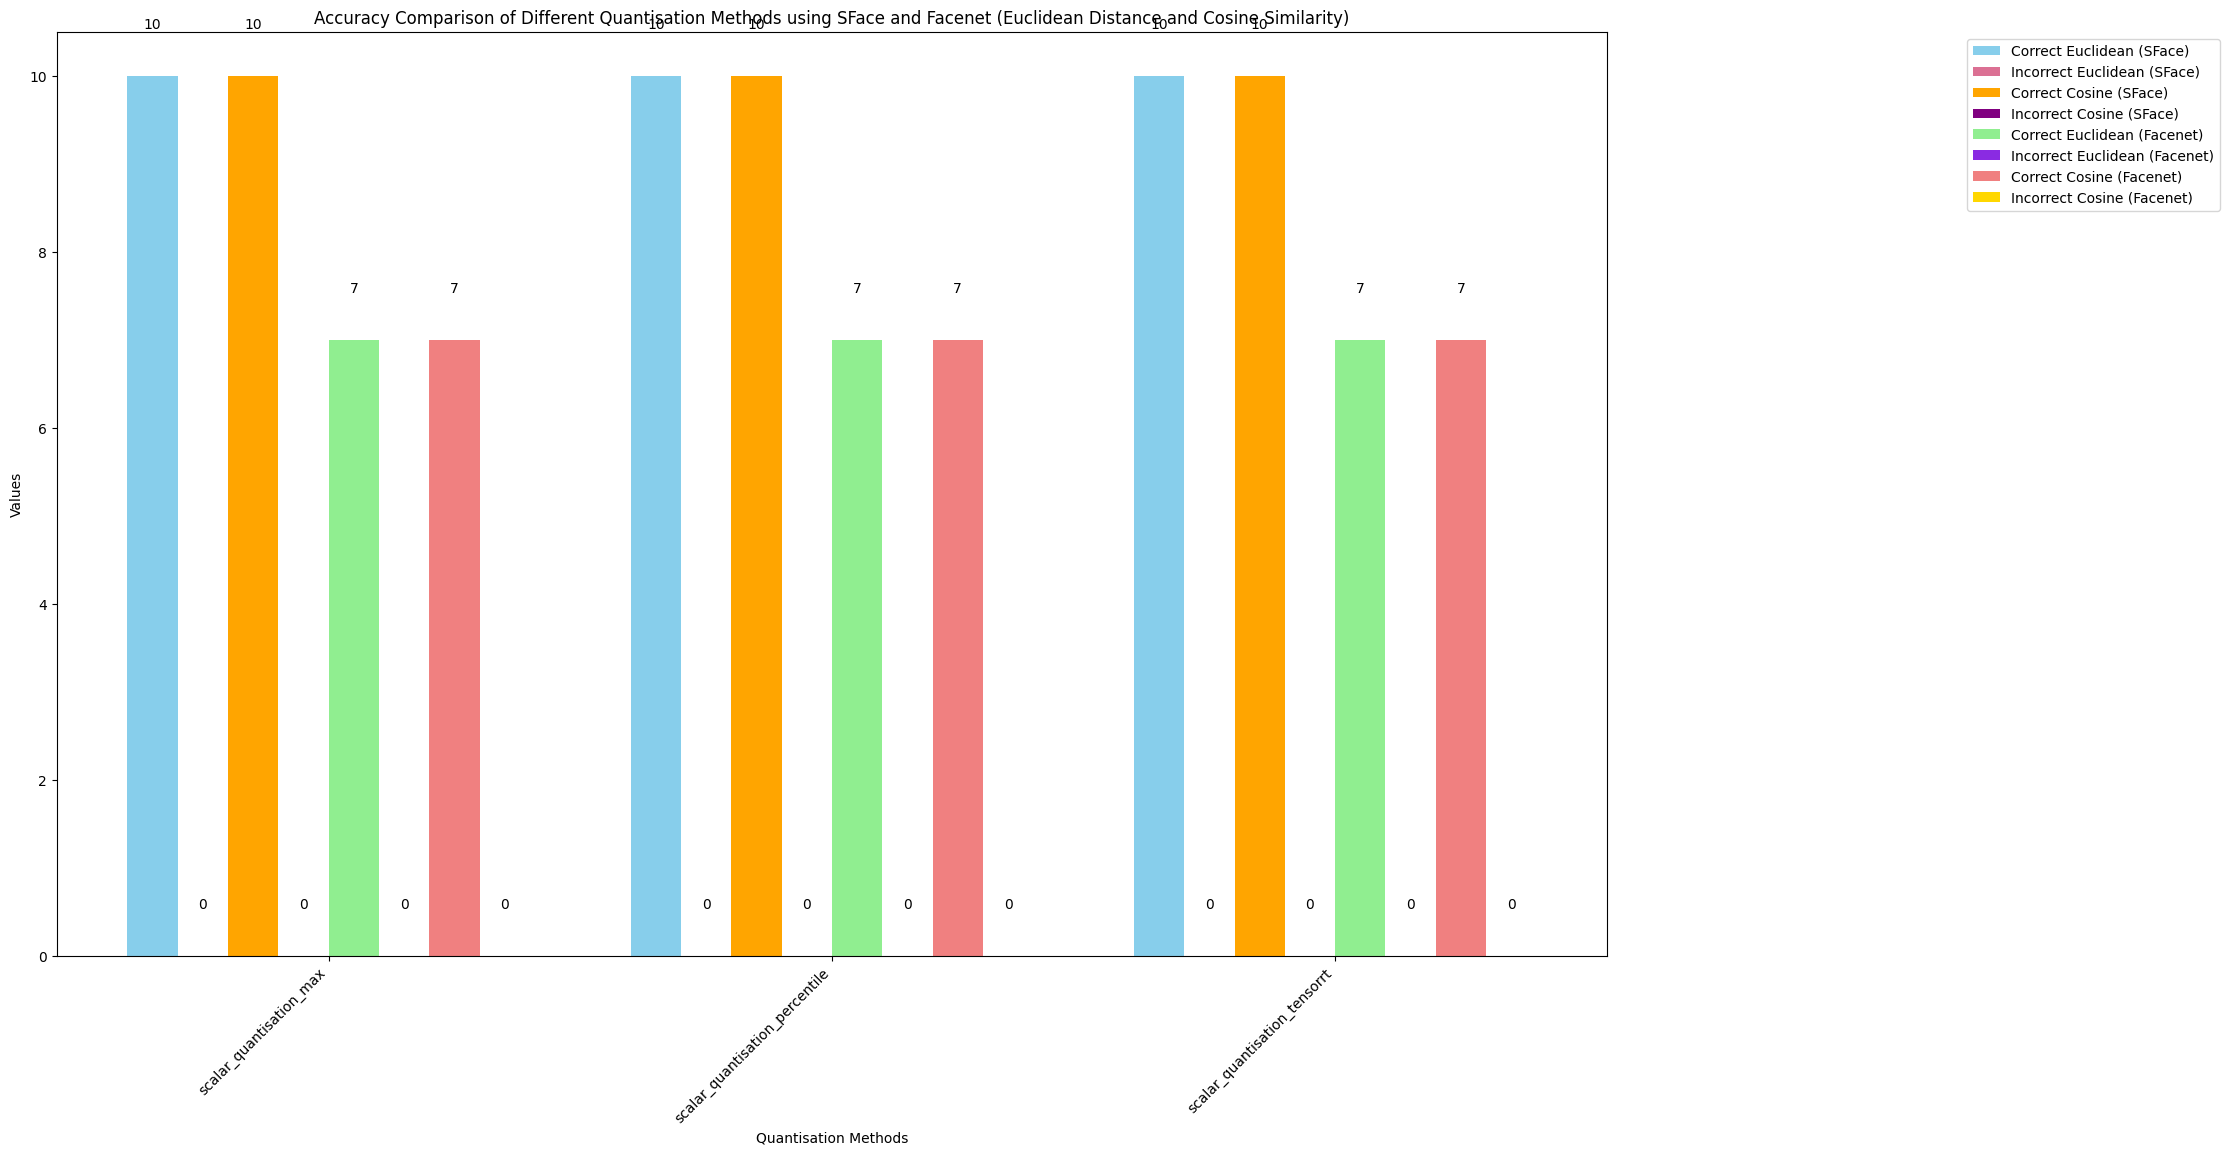

In [15]:
# Visualize the results
visualize_results(methods, correct_sface_euc, incorrect_sface_euc, correct_sface_cos, incorrect_sface_cos, correct_facenet_euc, incorrect_facenet_euc, correct_facenet_cos, incorrect_facenet_cos)

below will be the functions to compare the execution time of (Facenet, SFace) x (Euclidean, Cosine) X (no quantisation, Tensorflow, scalar)

In [17]:
# Calculate and print the average execution times
print("Average Execution Times (in seconds):")
for name in times_euc.keys():
    avg_tensor_time_euc = times_euc[name]['tensor_time'] / m  # Assuming m=1000
    avg_scalar_time_euc = times_euc[name]['scalar_time'] / m
    avg_noquant_time_euc = times_euc[name]['noquant_time'] / m
    
    avg_tensor_time_cos = times_cos[name]['tensor_time'] / m
    avg_scalar_time_cos = times_cos[name]['scalar_time'] / m
    avg_noquant_time_cos = times_cos[name]['noquant_time'] / m

    print(f"\nQuantization Method: {name}")
    print(f"  Total Tensor Time (Euclidean): {times_euc[name]['tensor_time']} seconds")
    print(f"  Total Scalar Time (Euclidean): {times_euc[name]['scalar_time']} seconds")
    print(f"  Total NoQuant Time (Euclidean): {times_euc[name]['noquant_time']} seconds")
    print(f"  Average Tensor Time (Euclidean): {avg_tensor_time_euc:.6f} seconds")
    print(f"  Average Scalar Time (Euclidean): {avg_scalar_time_euc:.6f} seconds")
    print(f"  Average NoQuant Time (Euclidean): {avg_noquant_time_euc:.6f} seconds")
    
    print(f"  Total Tensor Time (Cosine): {times_cos[name]['tensor_time']} seconds")
    print(f"  Total Scalar Time (Cosine): {times_cos[name]['scalar_time']} seconds")
    print(f"  Total NoQuant Time (Cosine): {times_cos[name]['noquant_time']} seconds")
    print(f"  Average Tensor Time (Cosine): {avg_tensor_time_cos:.6f} seconds")
    print(f"  Average Scalar Time (Cosine): {avg_scalar_time_cos:.6f} seconds")
    print(f"  Average NoQuant Time (Cosine): {avg_noquant_time_cos:.6f} seconds")


Average Execution Times (in seconds):

Quantization Method: scalar_quantisation_max
  Total Tensor Time (Euclidean): 0.01649188995361328 seconds
  Total Scalar Time (Euclidean): 0.0018351078033447266 seconds
  Total NoQuant Time (Euclidean): 0 seconds
  Average Tensor Time (Euclidean): 0.001649 seconds
  Average Scalar Time (Euclidean): 0.000184 seconds
  Average NoQuant Time (Euclidean): 0.000000 seconds
  Total Tensor Time (Cosine): 0.01649785041809082 seconds
  Total Scalar Time (Cosine): 0.002086639404296875 seconds
  Total NoQuant Time (Cosine): 0 seconds
  Average Tensor Time (Cosine): 0.001650 seconds
  Average Scalar Time (Cosine): 0.000209 seconds
  Average NoQuant Time (Cosine): 0.000000 seconds

Quantization Method: scalar_quantisation_percentile
  Total Tensor Time (Euclidean): 0.01649188995361328 seconds
  Total Scalar Time (Euclidean): 0.012440681457519531 seconds
  Total NoQuant Time (Euclidean): 0 seconds
  Average Tensor Time (Euclidean): 0.001649 seconds
  Average Sca